# **LightGCN (Light Graph Convolutional Network)**

Number of Users: 6022, Number of Items: 3043

Starting LightGCN training...
778/778 [==============================] - 1162s 1s/step - loss: 0.3994
Epoch 1/10 completed. Average loss: 0.399352
778/778 [==============================] - 1147s 1s/step - loss: 0.3165
Epoch 2/10 completed. Average loss: 0.316469
778/778 [==============================] - 1134s 1s/step - loss: 0.2828
Epoch 3/10 completed. Average loss: 0.282818
778/778 [==============================] - 1133s 1s/step - loss: 0.2644
Epoch 4/10 completed. Average loss: 0.264376
778/778 [==============================] - 1134s 1s/step - loss: 0.2530
Epoch 5/10 completed. Average loss: 0.252991
778/778 [==============================] - 1131s 1s/step - loss: 0.2448
Epoch 6/10 completed. Average loss: 0.244751
778/778 [==============================] - 1137s 1s/step - loss: 0.2378
Epoch 7/10 completed. Average loss: 0.237764
778/778 [==============================] - 1173s 2s/step - loss: 0.2317
Epoch 8/10 completed. Average los

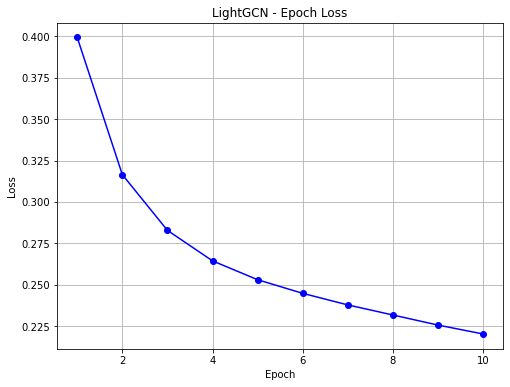


Evaluating on test data...

Evaluation Results (k=20):
  Recall@20:    0.132931
  NDCG@20:      0.288301


In [ ]:
import json
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
import random
from tensorflow.keras.utils import Progbar
import matplotlib.pyplot as plt
from collections import defaultdict

def load_mydataset(train_file, test_file, val_file):
    def read_json(path):
        with open(path, 'r') as f:
            return [set(x) for x in json.load(f)]

    train_list = read_json(train_file)
    test_list = read_json(test_file)
    val_list = read_json(val_file)

    train_items = {item for items in train_list for item in items}

    def filter_orphans(data_list, valid_items):
        # remove items not appear in train set
        return [{item for item in items if item in valid_items} for items in data_list]

    test_list = filter_orphans(test_list, train_items)
    val_list = filter_orphans(val_list, train_items)

    n_users = len(train_list)
    n_items = max(train_items) + 1 if train_items else 0

    return train_list, test_list, val_list, n_users, n_items

def build_adjacency_matrix(train_data, n_users, n_items):
    R_dok = sp.dok_matrix((n_users, n_items), dtype=np.float32)
    for u, items in enumerate(train_data):
        for i in items:
            R_dok[u, i] = 1.0
    R_csr = R_dok.tocsr()

    adj_size = n_users + n_items
    adj_dok = sp.dok_matrix((adj_size, adj_size), dtype=np.float32)
    # R in the upper-right block
    adj_dok[:n_users, n_users:] = R_csr
    # R^T in the lower-left block
    adj_dok[n_users:, :n_users] = R_csr.transpose()
    return adj_dok.tocsr()


def normalize_adj_sym(adj_mat):
    # symmetric normalization: D^-1/2 * A * D^-1/2.
    rowsum = np.array(adj_mat.sum(axis=1)).flatten() + 1e-9
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = sp.diags(d_inv_sqrt)
    return D_inv_sqrt.dot(adj_mat).dot(D_inv_sqrt)

class LightGCNModel(tf.keras.Model):
    def __init__(self, n_users, n_items, adj_mat, n_layers=3, emb_dim=64, decay=1e-4, use_personalized_alpha=False):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.adj_mat = adj_mat  # TF SparseTensor
        self.n_layers = n_layers
        self.emb_dim = emb_dim
        self.decay = decay
        self.use_personalized_alpha = use_personalized_alpha

        initializer = tf.initializers.GlorotUniform()
        self.user_embedding = self.add_weight(
            name='user_embedding',
            shape=(n_users, emb_dim),
            initializer=initializer,
            trainable=True
        )
        self.item_embedding = self.add_weight(
            name='item_embedding',
            shape=(n_items, emb_dim),
            initializer=initializer,
            trainable=True
        )

        if use_personalized_alpha:
            self.alpha_mlp = tf.keras.Sequential([
                tf.keras.layers.Dense(n_layers + 1, activation='softmax')
            ])
        
        # node attribute prediction (auxiliary task)
        self.attribute_predictor = tf.keras.layers.Dense(emb_dim, activation='relu', name="attribute_predictor")


    def call(self, embeddings, mask_prob=0.2):
        user_emb, item_emb = embeddings
        all_emb = tf.concat([user_emb, item_emb], axis=0)
        emb_list = [all_emb]
    
        # propagation layers
        for _ in range(self.n_layers):
            all_emb = tf.sparse.sparse_dense_matmul(self.adj_mat, all_emb)
            emb_list.append(all_emb)
    
        # combine embeddings from different layers
        if not self.use_personalized_alpha:
            alpha_k = 1.0 / (self.n_layers + 1)
            alpha_weights = [alpha_k] * (self.n_layers + 1)
            alpha_weights = tf.convert_to_tensor(alpha_weights, dtype=tf.float32)
            alpha_weights = tf.reshape(alpha_weights, (-1, 1, 1))
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha_weights, axis=0)
        else:
            alpha = self.alpha_mlp(emb_list[0])
            alpha = tf.expand_dims(alpha, axis=-1)
            stacked_emb = tf.stack(emb_list, axis=0)
            combined_emb = tf.reduce_sum(stacked_emb * alpha, axis=0)
    
        user_final, item_final = tf.split(combined_emb, [self.n_users, self.n_items], axis=0)
    
        # node attribute prediction
        masked_user_emb, mask = mask_embeddings(user_final, mask_prob)
        predicted_attributes = self.attribute_predictor(masked_user_emb)
        return user_final, item_final, masked_user_emb, predicted_attributes, mask


    def recommend(self, user_ids, k=10):
        user_final, item_final, _, _, _ = self((self.user_embedding, self.item_embedding))
        user_vecs = tf.gather(user_final, user_ids)
    
        all_recs = []
        for idx, uid in enumerate(user_ids):
            u_vec = user_vecs[idx:idx + 1]
            scores = tf.matmul(u_vec, item_final, transpose_b=True)  # (1, n_items)
            scores_np = scores.numpy().flatten()
            idx_topk = np.argsort(scores_np)[::-1][:k]
            score_topk = scores_np[idx_topk]
            for item_id, sc in zip(idx_topk, score_topk):
                all_recs.append((int(uid), int(item_id), float(sc)))
        return all_recs

def mask_embeddings(embeddings, mask_prob=0.2):
    mask = tf.cast(tf.random.uniform(embeddings.shape) > mask_prob, tf.float32)
    masked_embeddings = embeddings * mask
    return masked_embeddings, mask


def sample_neg(pos_items, n_items, strategy='random'):
    if strategy == 'random':
        neg_item = random.randint(0, n_items - 1)
        while neg_item in pos_items:
            neg_item = random.randint(0, n_items - 1)
    return neg_item


def train_lightgcn(model, train_data, n_users, n_items, batch_size=1024, epochs=10, initial_lr=1e-2, k=20):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # (user, item) pairs from train_data
    train_pairs = [(u, i) for u in range(n_users) for i in train_data[u]]
    steps_per_epoch = len(train_pairs) // batch_size + (len(train_pairs) % batch_size != 0)

    epoch_losses = []
    recall_scores = []
    ndcg_scores = []
    
    for epoch in range(1, epochs + 1):
        random.shuffle(train_pairs)
        progbar = Progbar(steps_per_epoch)

        epoch_loss = 0
        for step in range(steps_per_epoch):
            batch_slice = train_pairs[step * batch_size:(step + 1) * batch_size]
            users = [u for (u, _) in batch_slice]
            pos_items = [i for (_, i) in batch_slice]
            neg_items = [sample_neg(train_data[u], n_items) for (u, _) in batch_slice]

            users = np.array(users, dtype=np.int32)
            pos_items = np.array(pos_items, dtype=np.int32)
            neg_items = np.array(neg_items, dtype=np.int32)

            with tf.GradientTape() as tape:
                user_emb, item_emb, masked_user_emb, predicted_attributes, mask = model(
                    (model.user_embedding, model.item_embedding)
                )
                u_emb = tf.nn.embedding_lookup(user_emb, users)
                pos_emb = tf.nn.embedding_lookup(item_emb, pos_items)
                neg_emb = tf.nn.embedding_lookup(item_emb, neg_items)
            
                # BPR loss: mean( softplus(neg_score - pos_score) )
                pos_scores = tf.reduce_sum(u_emb * pos_emb, axis=1)
                neg_scores = tf.reduce_sum(u_emb * neg_emb, axis=1)
                mf_loss = tf.reduce_mean(tf.nn.softplus(neg_scores - pos_scores))
            
                # node attribute prediction loss
                attribute_loss = tf.reduce_mean(tf.square(masked_user_emb - predicted_attributes) * mask)
            
                # L2 Regularization
                reg_loss = model.decay * (
                    tf.nn.l2_loss(u_emb) + tf.nn.l2_loss(pos_emb) + tf.nn.l2_loss(neg_emb)
                ) / batch_size
            
                # total loss
                loss = mf_loss + reg_loss + 0.1 * attribute_loss  # Weighted auxiliary loss


            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss += loss.numpy()
            progbar.add(1, values=[('loss', float(loss))])

        avg_epoch_loss = epoch_loss / steps_per_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch}/{epochs} completed. Average loss: {avg_epoch_loss:.6f}")
        
        # evaluate on validation set
        val_users = [u for u in range(n_users) if len(val_data[u]) > 0]
        val_recs = model.recommend(val_users, k=k)
        epoch_recall = recall_at_k(val_recs, val_data, k=k)
        epoch_ndcg = ndcg(val_recs, val_data, k=k)

        recall_scores.append(epoch_recall)
        ndcg_scores.append(epoch_ndcg)
        print(f"Epoch {epoch}: Recall@{k}: {epoch_recall:.6f}, NDCG@{k}: {epoch_ndcg:.6f}")

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Loss")
    plt.title("LightGCN - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(recall_scores) + 1), recall_scores, marker='o', linestyle='-', color='g', label=f"Recall@{k}")
    plt.title(f"LightGCN - Recall@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(ndcg_scores) + 1), ndcg_scores, marker='o', linestyle='-', color='r', label=f"NDCG@{k}")
    plt.title(f"LightGCN - NDCG@{k}")
    plt.xlabel("Epoch")
    plt.ylabel("NDCG")
    plt.grid(True)
    plt.legend()
    plt.show()

    return epoch_losses, recall_scores, ndcg_scores

def recall_at_k(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    recalls = []
    for u, items_pred in user_recs.items():
        if len(test_data[u]) == 0:
            continue
        if k > 0:
            items_pred = items_pred[:k]
        gt = test_data[u]
        num_hit = len(set(items_pred).intersection(gt))
        recalls.append(num_hit / float(len(gt)))
    return np.mean(recalls) if recalls else 0.0

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.

def ndcg_at_k(recommended, ground_truth, k=10):
    rel = [1 if i in ground_truth else 0 for i in recommended[:k]]
    ideal_rel = sorted(rel, reverse=True)
    dcg = dcg_at_k(rel, k)
    idcg = dcg_at_k(ideal_rel, k)
    return (dcg / idcg) if idcg > 0 else 0.0

def ndcg(recs, test_data, k=10):
    user_recs = defaultdict(list)
    for (u, i, s) in recs:
        user_recs[u].append(i)
    ndcgs = []
    for u, items_pred in user_recs.items():
        gt = test_data[u]
        if len(gt) == 0:
            continue
        ndcgs.append(ndcg_at_k(items_pred, gt, k))
    return np.mean(ndcgs) if ndcgs else 0.0


def evaluate_lightgcn(model, users, test_data, ks=[5, 10, 20], batch_size=2000):
    all_recs = []
    idx_start = 0
    max_k = max(ks)
    while idx_start < len(users):
        idx_end = min(idx_start + batch_size, len(users))
        user_batch = users[idx_start:idx_end]
        recs_chunk = model.recommend(user_batch, k=max_k)
        all_recs.extend(recs_chunk)
        idx_start = idx_end

    results = {}
    for k in ks:
        rec = recall_at_k(all_recs, test_data, k=k)
        ndcg_ = ndcg(all_recs, test_data, k=k)
        results[k] = (rec, ndcg_)
        print(f"\nEvaluation Results (k={k}):")
        print(f"  Recall@{k}:    {rec:.6f}")
        print(f"  NDCG@{k}:      {ndcg_:.6f}")

    return results

train_file = 'C:/Users/xpati/Documents/TFG/ml-1m/train_data.json'
test_file = 'C:/Users/xpati/Documents/TFG/ml-1m/test_data.json'
val_file = 'C:/Users/xpati/Documents/TFG/ml-1m/validation_data.json'

train_data, test_data, val_data, n_users, n_items = load_mydataset(
    train_file, test_file, val_file
)
print(f"Number of Users: {n_users}, Number of Items: {n_items}")

adj_csr = build_adjacency_matrix(train_data, n_users, n_items)
norm_adj_csr = normalize_adj_sym(adj_csr)

# convert to TensorFlow SparseTensor
coo = norm_adj_csr.tocoo().astype(np.float32)
indices = np.vstack((coo.row, coo.col)).transpose()
A_tilde = tf.sparse.SparseTensor(indices=indices, values=coo.data, dense_shape=coo.shape)
A_tilde = tf.sparse.reorder(A_tilde)

N_LAYERS = 4
EMBED_DIM = 64
DECAY = 1e-3
INITIAL_LR = 1e-2
EPOCHS = 10
BATCH_SIZE = 1024

model = LightGCNModel(
    n_users=n_users,
    n_items=n_items,
    adj_mat=A_tilde,
    n_layers=N_LAYERS,
    emb_dim=EMBED_DIM,
    decay=DECAY,
    use_personalized_alpha=False
)

print("\nStarting LightGCN training...")
train_lightgcn(
    model=model,
    train_data=train_data,
    n_users=n_users,
    n_items=n_items,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    initial_lr=INITIAL_LR
)

print("\nEvaluating on test data...")
test_users = [u for u in range(n_users) if len(test_data[u]) > 0]
_ = evaluate_lightgcn(model, test_users, test_data, ks=[20])